# EPA1361 - Model-Based Decision Making
# Week 3 - Sensitivity analysis

This exercise uses the same predator-prey model we used for the multi-model exercise, focusing on the Python version. As with the other exercise, define a model object for the function below, with the uncertainty ranges provided:

|Parameter	|Range or value	        |
|-----------|--------------:|
|prey_birth_rate    	|0.015 – 0.035	|
|predation_rate|0.0005 – 0.003 	|
|predator_efficiency     	|0.001 – 0.004	    |
|predator_loss_rate	    |0.04 – 0.08	    |

* Sensitivity analysis often focuses on the final values of an outcome at the end of the simulation. However, we can also look at metrics that give us additional information about the behavior of the model over time. Using [the statsmodel library](https://www.statsmodels.org/stable/index.html) and an appropriate sampling design, fit a linear regression model for each of the following indicators. What can we conclude about the behavior of the model, and about the importance of the different inputs?

  * The final values of the _prey_ outcome
  * The mean values of the _prey_ outcome over time, within each experiment
  * The standard deviations of the _prey_ outcome over time, within each experiment
  

* Use the Sobol sampling functionality included in the Workbench to perform experiments with a sample size of N=50, then analyze the results with SALib for the same three indicators. This requires specifying the keyword argument `'uncertainty_sampling'` of perform_experiments. Note that when using Sobol sampling, the meaning of the keyword argument `scenarios` changes a bit. In order to properly estimate Sobol scores as well as interaction effects, you require N * (2D+2) scenarios, where D is the number of uncertain parameters, and N is the value for scenarios passed to `perform_experiments`. Repeat the analysis for larger sample sizes, with N=250 and N=1000. How can we interpret the first-order and total indices? Are these sample sizes sufficient for a stable estimation of the indices? You'll need to use the [get_SALib_problem](https://emaworkbench.readthedocs.io/en/latest/ema_documentation/em_framework/salib_samplers.html) function to convert your Workbench experiments to a problem definition that you can pass to the SALib analysis function. 

* *hint*: sobol is a deterministic sequence of quasi random numbers. Thus, you can run with N=1000 and simply slice for 1:50 and 1:250.

* Use the [Extra-Trees analysis](https://emaworkbench.readthedocs.io/en/latest/ema_documentation/analysis/feature_scoring.html) included in the Workbench to approximate the Sobol total indices, with a suitable sampling design. As a starting point, use an ensemble of 100 trees and a max_features parameter of 0.6, and set the analysis to regression mode. Are the estimated importances stable relative to the sample size and the analysis parameters? How do the results compare to the Sobol indices? For more details on this analysis see [Jaxa-Rozen & Kwakkel (2018)](https://www.sciencedirect.com/science/article/pii/S1364815217311581)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm


from ema_workbench import (Model, RealParameter, TimeSeriesOutcome, perform_experiments, ema_logging)



from ema_workbench.em_framework.evaluators import LHS, SOBOL, MORRIS
from ema_workbench import analysis
from ema_workbench.analysis import feature_scoring
from ema_workbench.analysis.scenario_discovery_util import RuleInductionType
from ema_workbench.em_framework.salib_samplers import get_SALib_problem
from SALib.analyze import sobol

def pred_prey(prey_birth_rate=0.025,
              predation_rate=0.0015, 
              predator_efficiency=0.002,
              predator_loss_rate=0.06, 
              initial_prey=50, 
              initial_predators=20, 
              dt=0.25, 
              final_time=365, reps=1):

    #Initial values
    predators = np.zeros((reps, int(final_time/dt)+1))
    prey = np.zeros((reps, int(final_time/dt)+1))
    sim_time = np.zeros((reps, int(final_time/dt)+1))
    
    for r in range(reps):
        predators[r,0] = initial_predators
        prey[r,0] = initial_prey

    #Calculate the time series
    for t in range(0, sim_time.shape[1]-1):

        dx = (prey_birth_rate*prey[r,t]) - (predation_rate*prey[r,t]*predators[r,t])
        dy = (predator_efficiency*predators[r,t]*prey[r,t]) - (predator_loss_rate*predators[r,t])

        prey[r,t+1] = max(prey[r,t] + dx*dt, 0)
        predators[r,t+1] = max(predators[r,t] + dy*dt, 0)
        sim_time[r,t+1] = (t+1)*dt
    
    #Return outcomes
    return {'TIME':sim_time,
            'predators':predators,
            'prey':prey}

# Setting up the ema_workbench model

In [2]:
from ema_workbench import (RealParameter, TimeSeriesOutcome, Constant,Model)


# defining a ema model object for the pred_prey function
model = Model('predprey', function= pred_prey)

#specifying uncertainties for the model
model.uncertainties = [RealParameter('prey_birth_rate', 0.015, 0.035),
                       RealParameter('predation_rate', 0.0005, 0.003),
                       RealParameter('predator_efficiency', 0.001, 0.004),
                       RealParameter('predator_loss_rate', 0.04, 0.08)]


#specifying outcomes
model.outcomes = [TimeSeriesOutcome('TIME'),
                  TimeSeriesOutcome('predators'),
                  TimeSeriesOutcome('prey')]

In [7]:
# Performing experiments
# Now that we have specified the model with the workbench, we will perform experiments on it

# Uncomment following code for multiprocessing (might need some additional configuration depending upon your computer.)
# from ema_workbench import (MultiprocessingEvaluator, ema_logging, perform_experiments)
# ema_logging.log_to_stderr(ema_logging.INFO)

# with MultiprocessingEvaluator(model) as evaluator:
#     results = evaluator.perform_experiments(scenarios=100)

#  Uncomment following code for sequential processing. This should work on all machines
from ema_workbench import SequentialEvaluator
ema_logging.log_to_stderr(ema_logging.INFO)
with SequentialEvaluator(model) as evaluator:
    results = evaluator.perform_experiments(scenarios=100, uncertainty_sampling=LHS)

[MainProcess/INFO] performing 100 scenarios * 1 policies * 1 model(s) = 100 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 10 cases completed
[MainProcess/INFO] 20 cases completed
[MainProcess/INFO] 30 cases completed
[MainProcess/INFO] 40 cases completed
[MainProcess/INFO] 50 cases completed
[MainProcess/INFO] 60 cases completed
[MainProcess/INFO] 70 cases completed
[MainProcess/INFO] 80 cases completed
[MainProcess/INFO] 90 cases completed
[MainProcess/INFO] 100 cases completed
[MainProcess/INFO] experiments finished


In [8]:
# Processing the results of the experiments
experiments, outcomes = results

# Note: for further processing of outcomes, I have converted the outcomes into a pandas dataframe. There are multiple ways of processing the outcomes and I have chosen pandas data frame because I am most familiar to its structure. If you have a more efficient way of doing this, feel free to comment out this cell and add your code :)

# converting the time series outcome predator into a  pandas dataframe
a = outcomes['predators']
m,n,r = a.shape
out_arr = np.column_stack((np.repeat(np.arange(m),n),a.reshape(m*n,-1)))
predators = pd.DataFrame(out_arr)

# converting the time series outcome prey into a  pandas dataframe
a = outcomes['prey']
m,n,r = a.shape
out_arr = np.column_stack((np.repeat(np.arange(m),n),a.reshape(m*n,-1)))
prey = pd.DataFrame(out_arr)




# Fitting the regression model

In [5]:
# Preparing data for fitting the regression model

# subsetting experiments for fitting the regression model
# extracting uncertainities from the column
X = experiments[['prey_birth_rate', 'predation_rate', 'predator_efficiency','predator_loss_rate']]


# Preparing a dataframe 'output' of model output indicators as specified in the assignment discription

output = pd.DataFrame(index = range(100), columns = ['predators_last', 'predators_mean','predators_std'] )

output['predators_last'] = predators.iloc[:,-1] # last value
output['predators_mean'] = predators.iloc[:,:].mean(axis=1) # mean value
output['predators_std'] = predators.iloc[:,:].std(axis=1) # standard deviation

output['prey_last'] = prey.iloc[:,-1] # last value
output['prey_mean'] = prey.iloc[:,:].mean(axis=1) # mean value
output['prey_std'] = prey.iloc[:,:].std(axis=1) # standard deviation

In [6]:
output

,predators_last,predators_mean,predators_std,prey_last,prey_mean,prey_std
0,1.528364,11.446094,13.149067,3.866372,14.162264,16.210433
1,22.653350,21.876145,5.344236,34.064589,41.956251,5.841420
2,15.796530,14.134167,4.659259,55.731714,41.612217,8.616153
3,32.992036,41.536437,29.064108,12.188842,29.854604,15.354296
4,10.098241,16.717190,21.170332,51.438542,21.872847,14.328035
...,...,...,...,...,...,...
95,2.125330,12.678828,16.861513,4.338351,16.983531,15.801887
96,18.281947,12.957893,8.128564,15.275883,31.193859,15.346897
97,27.324203,42.341271,23.562845,66.096085,39.093086,18.516853
98,8.074075,13.481036,4.767668,48.089146,47.634468,11.901770


                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.431
Model:                            OLS   Adj. R-squared (uncentered):              0.408
Method:                 Least Squares   F-statistic:                              18.21
Date:                Tue, 11 May 2021   Prob (F-statistic):                    3.69e-11
Time:                        01:11:02   Log-Likelihood:                         -459.36
No. Observations:                 100   AIC:                                      926.7
Df Residuals:                      96   BIC:                                      937.1
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
                          coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------

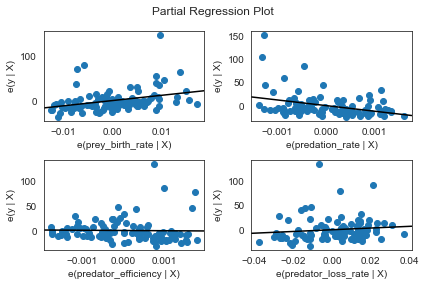

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.918
Model:                            OLS   Adj. R-squared (uncentered):              0.915
Method:                 Least Squares   F-statistic:                              270.0
Date:                Tue, 11 May 2021   Prob (F-statistic):                    2.66e-51
Time:                        01:11:04   Log-Likelihood:                         -331.92
No. Observations:                 100   AIC:                                      671.8
Df Residuals:                      96   BIC:                                      682.3
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
                          coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------

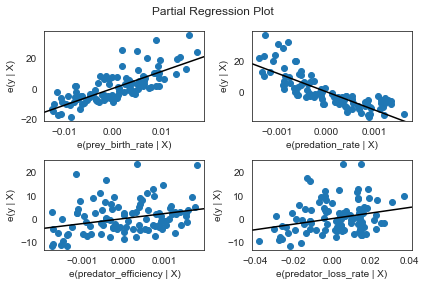

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.883
Model:                            OLS   Adj. R-squared (uncentered):              0.878
Method:                 Least Squares   F-statistic:                              180.5
Date:                Tue, 11 May 2021   Prob (F-statistic):                    9.49e-44
Time:                        01:11:06   Log-Likelihood:                         -346.29
No. Observations:                 100   AIC:                                      700.6
Df Residuals:                      96   BIC:                                      711.0
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
                          coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------

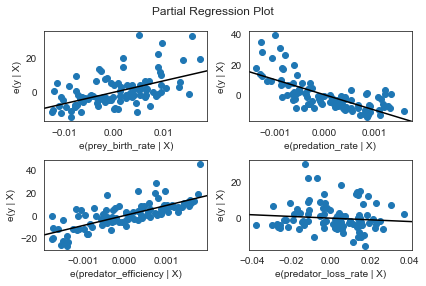

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.806
Model:                            OLS   Adj. R-squared (uncentered):              0.798
Method:                 Least Squares   F-statistic:                              99.67
Date:                Tue, 11 May 2021   Prob (F-statistic):                    2.63e-33
Time:                        01:11:08   Log-Likelihood:                         -406.42
No. Observations:                 100   AIC:                                      820.8
Df Residuals:                      96   BIC:                                      831.3
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
                          coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------

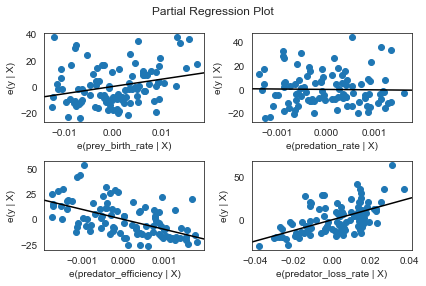

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.968
Model:                            OLS   Adj. R-squared (uncentered):              0.966
Method:                 Least Squares   F-statistic:                              718.2
Date:                Tue, 11 May 2021   Prob (F-statistic):                    1.39e-70
Time:                        01:11:10   Log-Likelihood:                         -311.23
No. Observations:                 100   AIC:                                      630.5
Df Residuals:                      96   BIC:                                      640.9
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
                          coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------

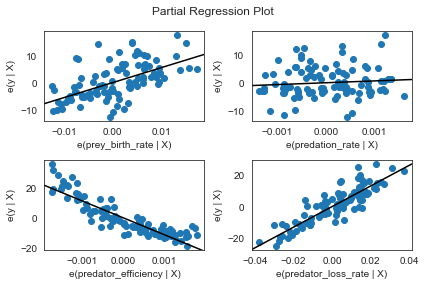

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.930
Model:                            OLS   Adj. R-squared (uncentered):              0.927
Method:                 Least Squares   F-statistic:                              317.1
Date:                Tue, 11 May 2021   Prob (F-statistic):                    2.13e-54
Time:                        01:11:12   Log-Likelihood:                         -282.03
No. Observations:                 100   AIC:                                      572.1
Df Residuals:                      96   BIC:                                      582.5
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
                          coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------

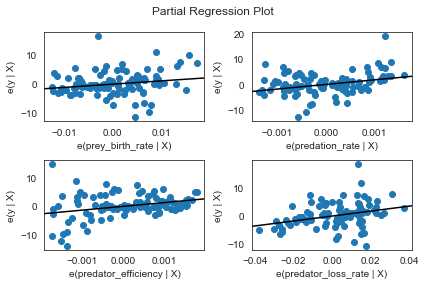

In [39]:
# Fitting regression model for every column in the dataframe outputs
for y in output.columns.to_list(): # iterating the columns of dataframe
    res = sm.OLS(output[y].to_numpy(),X).fit() # fitting the model
    print(res.summary()) # printing the summary
    fig = sm.graphics.plot_partregress_grid(res)
    ax.set_title(str(y))
    fig.tight_layout(pad=1.0) 
    plt.show()# Plotting the graphs

Based on the regression graphs and table above, following information can be deduced about the model behaviour. The behaviour of the model is close to reality. Prey birth rate is corelated to number of predators and prey in the model. This can also be explained as predators feed on prey and are dependet on them. Predition rate is an important input as it controls the prey population. Similarly, predators efficiency and predator loss rate helps in maintaning the equilibruim in the model. 

# Using Sobol sampling functionality to analyze the results with SALib for the same indicators

In [18]:
# Running the model with Sobol sampler and generating results
with SequentialEvaluator(model) as evaluator:
    sa_results = evaluator.perform_experiments(scenarios=100, uncertainty_sampling='sobol')

experiments, outcomes = sa_results

[MainProcess/INFO] performing 1000 scenarios * 1 policies * 1 model(s) = 1000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 100 cases completed
[MainProcess/INFO] 200 cases completed
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 700 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] experiments finished


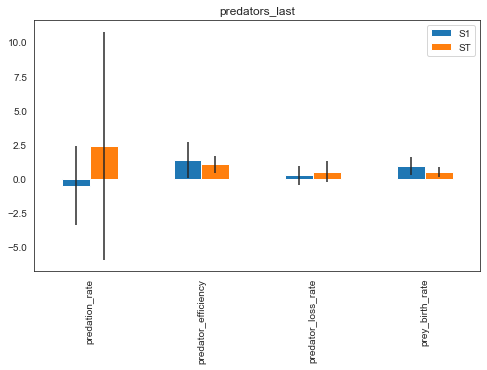

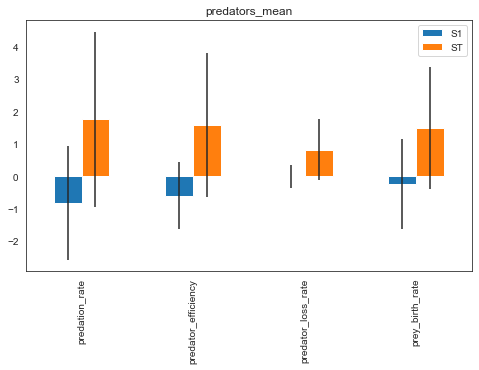

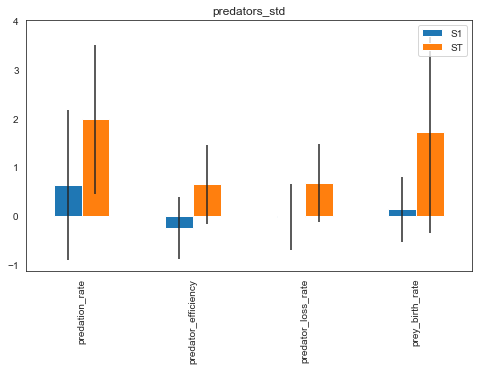

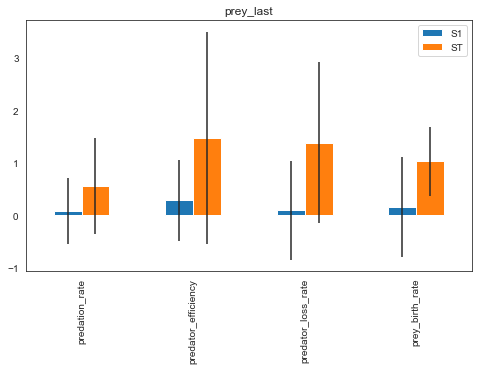

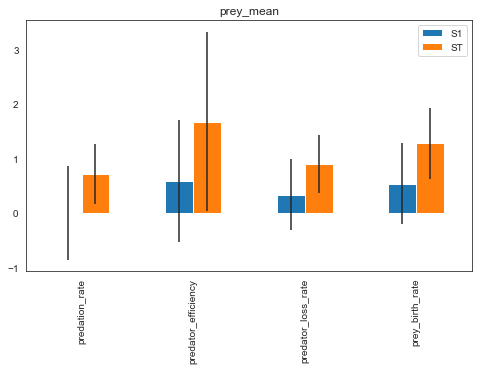

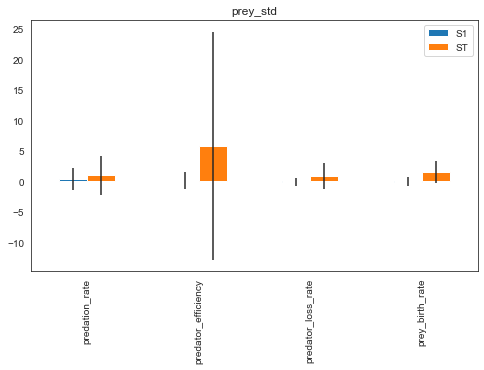

In [37]:
# Defining problem in SALib
problem = get_SALib_problem(model.uncertainties)

for y in output.columns.to_list(): # iterating the columns of dataframe
    Si = sobol.analyze(problem, output[y].to_numpy(), calc_second_order=True,print_to_console=False) # Getting SAlib index for each column in output dataframe

    # Processing the results for plotting the graph
    scores_filtered = {k:Si[k] for k in ['ST','ST_conf','S1','S1_conf']}
    Si_df = pd.DataFrame(scores_filtered, index=problem['names'])

    sns.set_style('white')
    fig, ax = plt.subplots(1)

    indices = Si_df[['S1','ST']]
    err = Si_df[['S1_conf','ST_conf']]

    indices.plot.bar(yerr=err.values.T,ax=ax)
    fig.set_size_inches(8,6)
    ax.set_title(str(y))
    fig.subplots_adjust(bottom=0.3)
    plt.show()

First-order and total indices shown in the graph above can be interpreted in the following manner:

* First order indices: Effect of uncertainity on its own (direct influence).
* Third order indices: Effect of uncertainity on its own along with its interactions with others (indirect influence).
From the above case, it can be said that all the unceratinities have more indirect influence through mutual interactions. This is evident through higher third order indices in all graphs.

Are these sample sizes sufficient for a stable estimation of the indices?
Sample size  = N * (2D+2)

N  = number of runs = 100

D = uncertanity dimensions = 4

Sample size = 1000

The required number of runs = 1000(k+2) = 1000(4+2) = 6000

Hence, sample size is not sufficient and analsis should be done again with runs = N = 6000

# Using the Extra-Trees analysis to compare with the Sobol indices

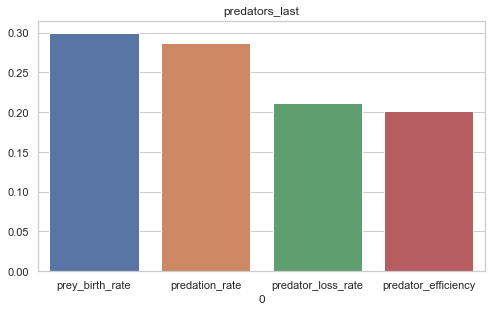

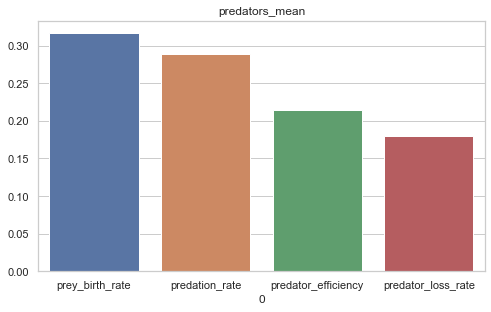

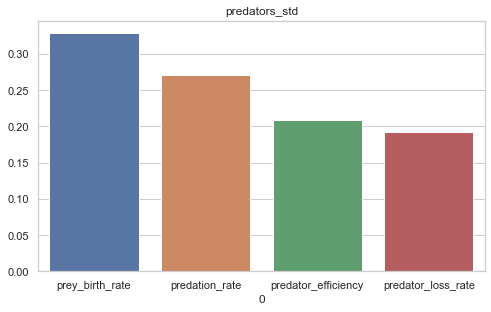

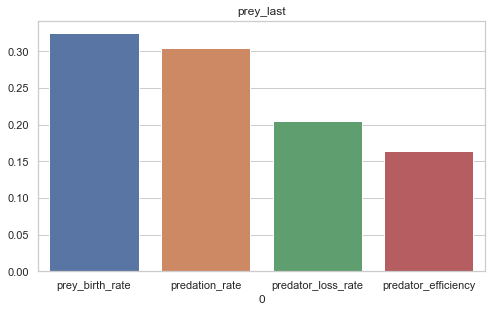

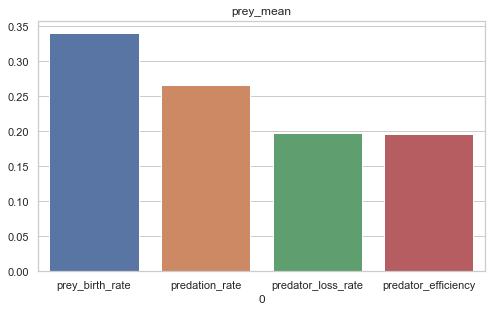

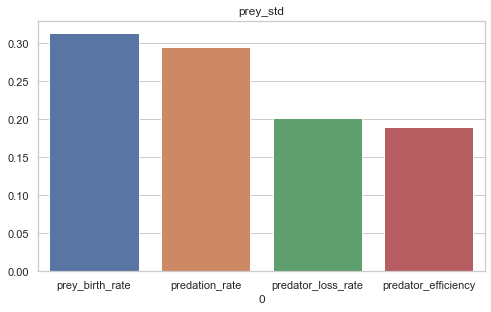

In [92]:

for y in output.columns.to_list(): # iterating the columns of dataframe

    # getting the score for extra -tree analysis
    uncertainty_score, extra_trees_regressor =feature_scoring.get_ex_feature_scores(x = X,
                                        y = output['predators_last'].to_numpy(),
                                        nr_trees=100,
                                        max_features = 0.6,
                                        mode = RuleInductionType.REGRESSION)

    # plotting the results
    sns.set_theme(style="whitegrid")
    fig, ax = plt.subplots(1)
    fig.set_size_inches(8,6)
    ax = sns.barplot( data=uncertainty_score.transpose())
    ax.set_title(str(y))
    fig.subplots_adjust(bottom=0.3)
    plt.show()

Number of runs = 100

Required number of runs >(100)k = 400

Thus, number of runs are not sufficient for yielding accurate results.



In extra trees all the graphs are giving same results but SAlib gave different result for each case. In addtion to this, SALib indices also gave additional information through first and third order indices of direct and indirect influence.